# Homework 3
### Daniela del Rio

### Part 1: Plan data only vs movement data

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spikeTimes = np.load('spikeTimes.npy', allow_pickle=True)
timeGoCue = np.load('timeGoCue.npy', allow_pickle=True)
timeTargetAcquire = np.load('timeTargetAcquire.npy', allow_pickle=True)
timeTouchHeld = np.load('timeTouchHeld.npy', allow_pickle=True)
cfr = np.load('cfr.npy', allow_pickle=True)

In [3]:
print(timeTouchHeld[0])
print(timeGoCue[0])
print(timeTargetAcquire[0])
print(spikeTimes[0][0]) # Claro, porque la neurona 0 disparo 3 veces, en la prueba 0.
# Y los tiempos que dice ahi es cuando ocurrio eso, que fue entre timeTouchHeld y timeGoCue
# print(spikeTimes)

480
1485
2005
[549.51354167 595.64166667 669.74583333]


In [4]:
# Modified example code for finding the number of spikes in the plan and movement window

planSpikes = []
movementSpikes = []

for trialIdx, trialSpikes in enumerate(spikeTimes): #what does st mean?
    planSpikes.append([np.sum((st > timeTouchHeld[trialIdx]) & (st < timeGoCue[trialIdx])) for st in trialSpikes])
    movementSpikes.append([np.sum((st > timeGoCue[trialIdx]) & (st < timeTargetAcquire[trialIdx])) for st in trialSpikes])

planSpikes = np.array(planSpikes) # will be 1127 x 190 (number of trials by number of neurons)
movementSpikes = np.array(movementSpikes) # will be 1127 x 190 (number of trials by number of neurons)
# planSpikes, movementSpikes

### Obtaining the rates (lambdas) for each neuron in each trial in the plan, movement and trial-movement window

In [5]:
def all_lambdas(neuron_indices, planSpikes, movementSpikes, timeGoCue, timeTouchHeld, timeTargetAcquire):
    
    trials = 1127
    neurons = len(neuron_indices)

    lambda_planSpikes = np.zeros((trials,neurons))
    lambda_movementSpikes = np.zeros((trials,neurons))
    lambda_plan_move_Spikes = np.zeros((trials,neurons))

    # Careful! You must use the correct indices

    for trial_i in range(trials):
        for neuron_i in range(neurons):
            original_neu_i = neuron_indices[neuron_i]

            lambda_planSpikes[trial_i][neuron_i] = planSpikes[trial_i][original_neu_i]/(timeGoCue[trial_i]-timeTouchHeld[trial_i])
            lambda_movementSpikes[trial_i][neuron_i] = movementSpikes[trial_i][original_neu_i]/(timeTargetAcquire[trial_i]-timeGoCue[trial_i])

            #Combined data
            spikes = planSpikes[trial_i][original_neu_i] + movementSpikes[trial_i][original_neu_i]
            time_window = (timeGoCue[trial_i]-timeTouchHeld[trial_i]) + (timeTargetAcquire[trial_i]-timeGoCue[trial_i])
            lambda_plan_move_Spikes[trial_i][neuron_i] = spikes/time_window
            
    return lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes

In [6]:
# Training data
# The cfr has the objective of each trial.
# Randomly choose 50 data sets for each direction, that is 400 sets in total.
def Training_data_and_lambdas(cfr, lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes,
                              neuron_indices=[i for i in range(190)], data_sets=50):
    trials = 1127
    neurons = len(neuron_indices)
    
    # Indices of each objective
    vec_1 = [i for i in range(len(cfr)) if cfr[i] == 1]
    vec_2 = [i for i in range(len(cfr)) if cfr[i] == 2]
    vec_3 = [i for i in range(len(cfr)) if cfr[i] == 3]
    vec_4 = [i for i in range(len(cfr)) if cfr[i] == 4]
    vec_5 = [i for i in range(len(cfr)) if cfr[i] == 5]
    vec_6 = [i for i in range(len(cfr)) if cfr[i] == 6]
    vec_7 = [i for i in range(len(cfr)) if cfr[i] == 7]
    vec_8 = [i for i in range(len(cfr)) if cfr[i] == 8]

    # Training indices for each objective
    training_1 = random.sample(vec_1, data_sets)
    training_2 = random.sample(vec_2, data_sets)
    training_3 = random.sample(vec_3, data_sets)
    training_4 = random.sample(vec_4, data_sets)
    training_5 = random.sample(vec_5, data_sets)
    training_6 = random.sample(vec_6, data_sets)
    training_7 = random.sample(vec_7, data_sets)
    training_8 = random.sample(vec_8, data_sets)
    
    # Organizing the training and testing indices
    training_indices = np.column_stack((training_1, training_2, training_3, training_4,
                                        training_5, training_6, training_7, training_8))
    training_indices = training_indices.reshape(400)
    training_indices = np.sort(training_indices)
#     training_indices

    testing_indices = []

    for i in range(trials):
        if i not in training_indices:
            testing_indices.append(i)
            
    # Obtaining the lambdas we will use for evaluating in the Poisson model
    # There are lambdas for planning, movement and plan_movement epochs.

    lambda_plan = np.zeros((8, neurons))
    lambda_movement = np.zeros((8, neurons))
    lambda_plan_move = np.zeros((8, neurons))

    for neuron_i in range(neurons):
        for i in training_1: #Cycle for training data in 1st direction
            
            lambda_plan[0][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[0][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[0][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_2: #Cycle for training data in 2nd direction
            lambda_plan[1][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[1][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[1][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_3: #Cycle for training data in 3rd direction
            lambda_plan[2][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[2][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[2][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_4: #Cycle for training data in 4th direction
            lambda_plan[3][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[3][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[3][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_5: #Cycle for training data in 5th direction
            lambda_plan[4][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[4][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[4][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_6: #Cycle for training data in 6th direction
            lambda_plan[5][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[5][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[5][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_7: #Cycle for training data in 7th direction
            lambda_plan[6][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[6][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[6][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

        for i in training_8: #Cycle for training data in 8th direction
            lambda_plan[7][neuron_i] += lambda_planSpikes[i][neuron_i] # Lambda for neuron i
            lambda_movement[7][neuron_i] += lambda_movementSpikes[i][neuron_i] # Lambda for neuron i
            lambda_plan_move[7][neuron_i] += lambda_plan_move_Spikes[i][neuron_i] # Lambda for neuron i

    lambda_plan = lambda_plan/50
    lambda_movement = lambda_movement/50
    lambda_plan_move = lambda_plan_move/50

    return testing_indices, lambda_plan, lambda_movement, lambda_plan_move # Vectors of 8*190 = 1520

In [7]:
# Likelihood equation
def Poisson(x_d, lambda_d): #This formula is only for the testing data

    if lambda_d < 1e-100: # Very small lambdas return a value that goes to infty.
        log_term = -230*x_d
    else:
        log_term = x_d*np.log(lambda_d)
        
#     if x_d >20: # For more than 20 spikes, the log(spikes!) comes with an error message
#         # AttributeError: 'int' object has no attribute 'log'
#         # np.log(math.factorial(20)) # For numbers greater than 20, there comes this error message
#         factorial = np.log(np.double(np.math.factorial(x_d)))
#     else:
#         factorial = np.log(math.factorial(x_d))
        
    return -lambda_d + log_term # - factorial
# Note the factorial term does not matter because it is the same term for each direction, so when you compare them,
# it does not make a difference

In [8]:
def complete_process(neuron_indices, planSpikes, movementSpikes, timeGoCue, timeTouchHeld, timeTargetAcquire, cfr):
    neurons = len(neuron_indices)
    lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes = all_lambdas(neuron_indices, planSpikes,
                                                                                    movementSpikes, timeGoCue,
                                                                                    timeTouchHeld, timeTargetAcquire)
    testing_indices, lambda_plan, lambda_movement, lambda_plan_move = Training_data_and_lambdas(cfr, lambda_planSpikes,
                                                                                                lambda_movementSpikes,
                                                                                                lambda_plan_move_Spikes,
                                                                                               neuron_indices)

    # Poisson values for the planning and movement data
    direction_values_plan = np.zeros(len(testing_indices))
    direction_values_move = np.zeros(len(testing_indices))
    direction_values_plan_move = np.zeros(len(testing_indices))
    i = 0

    for testing_i in testing_indices:
        aux_plan = np.zeros(8)
        aux_move = np.zeros(8)
        aux_plan_move = np.zeros(8)

        for direction_i in range(8):
            for neuron_i in range(neurons):

                aux_plan[direction_i] += Poisson(lambda_planSpikes[testing_i][neuron_i], lambda_plan[direction_i][neuron_i])
                aux_move[direction_i] += Poisson(lambda_movementSpikes[testing_i][neuron_i], lambda_movement[direction_i][neuron_i])
                aux_plan_move[direction_i] += Poisson(lambda_plan_move_Spikes[testing_i][neuron_i], lambda_plan_move[direction_i][neuron_i])

        # These last 3 arrays cannot be called with the same index as the original values.
        direction_values_plan[i] = np.argmax(aux_plan)+1
        direction_values_move[i] = np.argmax(aux_move)+1
        direction_values_plan_move[i] = np.argmax(aux_plan_move)+1

        i+=1 # This is only an index for the testing_indices

    # Correctness of trials
    i = 0
    correct_trials_plan = 0
    correct_trials_move = 0
    correct_trials_plan_move = 0

    # Yes, you must call them with different indices because they have different sizes.
    # But you did the correct mapping.
    for testing_i in testing_indices:

        if cfr[testing_i] == direction_values_plan[i]:
            correct_trials_plan += 1

        if cfr[testing_i] == direction_values_move[i]:
            correct_trials_move += 1

        if cfr[testing_i] == direction_values_plan_move[i]:
            correct_trials_plan_move += 1

        i += 1

    return [correct_trials_plan/len(testing_indices), correct_trials_move/len(testing_indices), correct_trials_plan_move/len(testing_indices)]

In [9]:
neuron_indices = [i for i in range(190)]

correct_plan, correct_move, correct_plan_move = complete_process(neuron_indices, planSpikes, movementSpikes,
                                                                 timeGoCue, timeTouchHeld, timeTargetAcquire, cfr)
print("Correct trials in planning: ", correct_plan)
print("Correct trials in movement: ", correct_move)
print("Correct trials in planning and movement: ", correct_plan_move)

Correct trials in planning:  0.8872077028885832
Correct trials in movement:  0.9312242090784044
Correct trials in planning and movement:  0.9724896836313618


### Part 2: Amount of plan data

a. The plan periods in the data set are either 755 or 1005 ms. Consider decoding using less than the full plan period. Generate new models for plan periods of increasing size (50 ms to 750 ms in 50 ms increments, where all plan windows begin at the target onset time). Using maximum likelihood estimation, decode the reach target for the test data using these different sized windows of neural data. (Both train and test with these window sizes!) Plot the decoding accuracy as a function of the size of the decoding window. Briefly describe what you see. (20 pts)

In [10]:
# Finds the number of spikes in the MODIFIED plan window
def spikes_window(time_window, spikeTimes, trialSpikes, timeTouchHeld):
    mod_planSpikes = []
    mod_movementSpikes = []

    for trialIdx, trialSpikes in enumerate(spikeTimes): #what does st mean? The iteration variable
        mod_planSpikes.append([np.sum((st > timeTouchHeld[trialIdx]) & (st < timeTouchHeld[trialIdx]+time_window)) for st in trialSpikes])
        mod_movementSpikes.append([np.sum((st > timeGoCue[trialIdx]) & (st < timeGoCue[trialIdx]+time_window)) for st in trialSpikes])
        
    mod_planSpikes = np.array(mod_planSpikes) # will be 1127 x 190 (number of trials by number of neurons)
    mod_movementSpikes = np.array(mod_movementSpikes) # will be 1127 x 190 (number of trials by number of neurons)
    
    return mod_planSpikes, mod_movementSpikes

In [11]:
# Modified version of all_lambdas
def Change_time_window_V2(time_window, spikeTimes, trialSpikes, timeTouchHeld):
    mod_planSpikes, mod_movementSpikes = spikes_window(time_window, spikeTimes, trialSpikes, timeTouchHeld)
    
    neuron_indices = [i for i in range(190)]
    
    # function all lambdas
    trials = 1127
    neurons = len(neuron_indices)

    lambda_planSpikes = np.zeros((trials,neurons))
    lambda_movementSpikes = np.zeros((trials,neurons))
    lambda_plan_move_Spikes = np.zeros((trials,neurons))

    for trial_i in range(trials):
        for neuron_i in range(neurons):
            original_neu_i = neuron_i

            lambda_planSpikes[trial_i][neuron_i] = mod_planSpikes[trial_i][original_neu_i]/time_window
            lambda_movementSpikes[trial_i][neuron_i] = mod_movementSpikes[trial_i][original_neu_i]/time_window

            #Combined data
            spikes = mod_planSpikes[trial_i][original_neu_i] + mod_movementSpikes[trial_i][original_neu_i]
            lambda_plan_move_Spikes[trial_i][neuron_i] = spikes/(2*time_window)
    
    return lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes

In [12]:
# Rest of code in Complete_precess function, but now for changing the time window
time_window_i = 0
n = 15

time_windows = [i*50+50 for i in range(n)]
correct_plans = np.zeros(n)
correct_moves = np.zeros(n)
correct_plan_moves = np.zeros(n)

for time_window in time_windows:
    print("Running "+str(time_windows[time_window_i])+"ms time window.")
    
    lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes = Change_time_window_V2(time_window, spikeTimes, trialSpikes, timeTouchHeld)
    testing_indices, lambda_plan, lambda_movement, lambda_plan_move = Training_data_and_lambdas(cfr, lambda_planSpikes,
                                                                                                lambda_movementSpikes,
                                                                                                lambda_plan_move_Spikes)

    # Poisson values for the planning and movement data
    direction_values_plan = np.zeros(len(testing_indices))
    direction_values_move = np.zeros(len(testing_indices))
    direction_values_plan_move = np.zeros(len(testing_indices))
    i = 0

    for testing_i in testing_indices:
        aux_plan = np.zeros(8)
        aux_move = np.zeros(8)
        aux_plan_move = np.zeros(8)

        for direction_i in range(8):
            for neuron_i in range(190):

                aux_plan[direction_i] += Poisson(lambda_planSpikes[testing_i][neuron_i], lambda_plan[direction_i][neuron_i])
                aux_move[direction_i] += Poisson(lambda_movementSpikes[testing_i][neuron_i], lambda_movement[direction_i][neuron_i])
                aux_plan_move[direction_i] += Poisson(lambda_plan_move_Spikes[testing_i][neuron_i], lambda_plan_move[direction_i][neuron_i])

        # These last 3 arrays cannot be called with the same index as the original values.
        direction_values_plan[i] = np.argmax(aux_plan)+1
        direction_values_move[i] = np.argmax(aux_move)+1
        direction_values_plan_move[i] = np.argmax(aux_plan_move)+1

        i+=1 # This is only an index for the testing_indices

    # Correctness of trials
    i = 0
    correct_trials_plan = 0
    correct_trials_move = 0
    correct_trials_plan_move = 0

    # Yes, you must call them with different indices because they have different sizes.
    # But you did the correct mapping.
    for testing_i in testing_indices:

        if cfr[testing_i] == direction_values_plan[i]:
            correct_trials_plan += 1

        if cfr[testing_i] == direction_values_move[i]:
            correct_trials_move += 1

        if cfr[testing_i] == direction_values_plan_move[i]:
            correct_trials_plan_move += 1

        i += 1

    correct_plans[time_window_i] = correct_trials_plan/len(testing_indices)
    correct_moves[time_window_i] = correct_trials_move/len(testing_indices)
    correct_plan_moves[time_window_i] = correct_trials_plan_move/len(testing_indices)
    
    time_window_i += 1

Running 50ms time window.
Running 100ms time window.
Running 150ms time window.
Running 200ms time window.
Running 250ms time window.
Running 300ms time window.
Running 350ms time window.
Running 400ms time window.
Running 450ms time window.
Running 500ms time window.
Running 550ms time window.
Running 600ms time window.
Running 650ms time window.
Running 700ms time window.
Running 750ms time window.


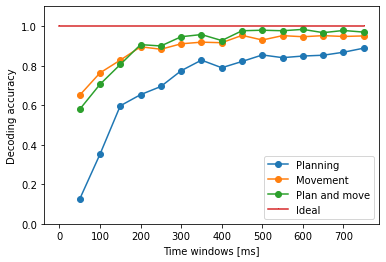

In [13]:
plt.plot(time_windows, correct_plans, marker="o", label = "Planning")
plt.plot(time_windows, correct_moves, marker="o", label = "Movement")
plt.plot(time_windows, correct_plan_moves, marker="o", label = "Plan and move")
plt.plot([0, 750], [1, 1], marker = ",", label="Ideal")
plt.xlabel("Time windows [ms]")
plt.ylabel("Decoding accuracy")
plt.legend()
plt.ylim([0, 1.1])
plt.show()

Notice how in the previous plot, the 3 groups of data follow the same tendency. As the time window becomes bigger, the decoding accuracy is higher. This tendency occursa for less than 300 ms time windows. For time windows higher than 300 ms, we could say that this decoding accuracy is constant because the slope of the curve is almost zero.

### Part 2 of question 2: sliding window
b. Now, instead of using an increasing window size, use a constant 200 ms window, but slide the window start time from target onset (“0”) to 550 ms after target onset (use 50 ms steps). Generate new models for each window location and decode the reach target for the test data. Plot the decoding accuracy as a function of the temporal location of the decoding window. Briefly describe what you see. (20 pts)

In [14]:
# Finds the number of spikes in the SLIDING time window
def spikes_sliding_window(init_window, end_window, spikeTimes, trialSpikes, timeTouchHeld):
    mod_planSpikes = []
    mod_movementSpikes = []

    # We are only interested in the number of spikes that occur in the designated time window.
    # From the onset of plan or movement plus the displacement init_window or end_window.
    for trialIdx, trialSpikes in enumerate(spikeTimes):
        mod_planSpikes.append([np.sum((st > timeTouchHeld[trialIdx]+init_window) & (st < timeTouchHeld[trialIdx]+end_window)) for st in trialSpikes])
        mod_movementSpikes.append([np.sum((st > timeGoCue[trialIdx]+init_window) & (st < timeGoCue[trialIdx]+end_window)) for st in trialSpikes])
        
    mod_planSpikes = np.array(mod_planSpikes) # will be 1127 x 190 (number of trials by number of neurons)
    mod_movementSpikes = np.array(mod_movementSpikes) # will be 1127 x 190 (number of trials by number of neurons)
    
    return mod_planSpikes, mod_movementSpikes

# Modified version of all_lambdas for sliding window
def Change_time_window_V2_sliding(init_window, end_window, spikeTimes, trialSpikes, timeTouchHeld):
    mod_planSpikes, mod_movementSpikes = spikes_sliding_window(init_window, end_window, spikeTimes, trialSpikes, timeTouchHeld)
    
    neuron_indices = [i for i in range(190)]
    
    # function all lambdas
    trials = 1127
    neurons = len(neuron_indices)

    lambda_planSpikes = np.zeros((trials,neurons))
    lambda_movementSpikes = np.zeros((trials,neurons))
    lambda_plan_move_Spikes = np.zeros((trials,neurons))
    
    time_window = end_window - init_window

    for trial_i in range(trials):
        for neuron_i in range(neurons):
            original_neu_i = neuron_i

            lambda_planSpikes[trial_i][neuron_i] = mod_planSpikes[trial_i][original_neu_i]/time_window
            lambda_movementSpikes[trial_i][neuron_i] = mod_movementSpikes[trial_i][original_neu_i]/time_window

            #Combined data
            spikes = mod_planSpikes[trial_i][original_neu_i] + mod_movementSpikes[trial_i][original_neu_i]
            lambda_plan_move_Spikes[trial_i][neuron_i] = spikes/(2*time_window)
    
    return lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes

In [15]:
n = 12
sliding_window_init = [i*50 for i in range(n)] #left_window
# print(sliding_window_init)
sliding_window_end = [i*50+200 for i in range(n)]
# print(sliding_window_end)

correct_plans = np.zeros(n)
correct_moves = np.zeros(n)
correct_plan_moves = np.zeros(n)


for window_i in range(n):
    init_window = sliding_window_init[window_i]
    end_window = sliding_window_end[window_i]

    print("Running "+str(init_window)+" to "+str(end_window)+"ms time window.")
    
    lambda_planSpikes, lambda_movementSpikes, lambda_plan_move_Spikes = Change_time_window_V2_sliding(init_window, end_window, spikeTimes, trialSpikes, timeTouchHeld)

    # Rest of code in Complete_precess function, but now for changing the time window
        
    testing_indices, lambda_plan, lambda_movement, lambda_plan_move = Training_data_and_lambdas(cfr, lambda_planSpikes,
                                                                                                lambda_movementSpikes,
                                                                                                lambda_plan_move_Spikes)

    # Poisson values for the planning and movement data
    direction_values_plan = np.zeros(len(testing_indices))
    direction_values_move = np.zeros(len(testing_indices))
    direction_values_plan_move = np.zeros(len(testing_indices))
    i = 0

    for testing_i in testing_indices:
        aux_plan = np.zeros(8)
        aux_move = np.zeros(8)
        aux_plan_move = np.zeros(8)

        for direction_i in range(8):
            for neuron_i in range(190):

                aux_plan[direction_i] += Poisson(lambda_planSpikes[testing_i][neuron_i], lambda_plan[direction_i][neuron_i])
                aux_move[direction_i] += Poisson(lambda_movementSpikes[testing_i][neuron_i], lambda_movement[direction_i][neuron_i])
                aux_plan_move[direction_i] += Poisson(lambda_plan_move_Spikes[testing_i][neuron_i], lambda_plan_move[direction_i][neuron_i])

        # These last 3 arrays cannot be called with the same index as the original values.
        direction_values_plan[i] = np.argmax(aux_plan)+1
        direction_values_move[i] = np.argmax(aux_move)+1
        direction_values_plan_move[i] = np.argmax(aux_plan_move)+1

        i+=1 # This is only an index for the testing_indices

    # Correctness of trials
    i = 0
    correct_trials_plan = 0
    correct_trials_move = 0
    correct_trials_plan_move = 0

    # Yes, you must call them with different indices because they have different sizes.
    # But you did the correct mapping.
    for testing_i in testing_indices:

        if cfr[testing_i] == direction_values_plan[i]:
            correct_trials_plan += 1

        if cfr[testing_i] == direction_values_move[i]:
            correct_trials_move += 1

        if cfr[testing_i] == direction_values_plan_move[i]:
            correct_trials_plan_move += 1

        i += 1

    correct_plans[window_i] = correct_trials_plan/len(testing_indices)
    correct_moves[window_i] = correct_trials_move/len(testing_indices)
    correct_plan_moves[window_i] = correct_trials_plan_move/len(testing_indices)

Running 0 to 200ms time window.
Running 50 to 250ms time window.
Running 100 to 300ms time window.
Running 150 to 350ms time window.
Running 200 to 400ms time window.
Running 250 to 450ms time window.
Running 300 to 500ms time window.
Running 350 to 550ms time window.
Running 400 to 600ms time window.
Running 450 to 650ms time window.
Running 500 to 700ms time window.
Running 550 to 750ms time window.


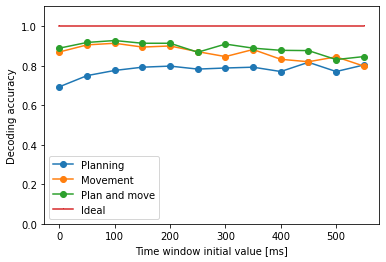

In [16]:
plt.plot(sliding_window_init, correct_plans, marker="o", label = "Planning")
plt.plot(sliding_window_init, correct_moves, marker="o", label = "Movement")
plt.plot(sliding_window_init, correct_plan_moves, marker="o", label = "Plan and move")
plt.plot([0, 550], [1, 1], marker = ",", label="Ideal")
plt.xlabel("Time window initial value [ms]")
plt.ylabel("Decoding accuracy")
plt.legend()
plt.ylim([0, 1.1])
plt.show()

### Part 3: Number of neurons

Using your model from (1), you decoded maximum likelihood targets using all 190 neurons. Now, perform a “neuron dropping analysis”. Starting with your full model, randomly eliminate neurons and evaluate decoding accuracy in the reduced data set. Eliminate between 20 and 180 neurons (by 20s – so decode using between 10 and 190 neurons in steps of 20) – average each point (number of neurons) by randomly choosing neurons to be dropped 20 times. Plot decoding accuracy as a function of the number of neurons available to the decoder. Briefly describe what you see?


In [19]:
def neuron_drop(eliminated, neurons = 190):
    return np.sort(random.sample([i for i in range(neurons)], neurons-eliminated))

In [20]:
n = 10
amount_of_neurons = [i*20 for i in range(n)]

correct_plans = np.zeros(n)
correct_moves = np.zeros(n)
correct_plan_moves = np.zeros(n)

for i in range(len(amount_of_neurons)):
    print("Dropping "+str(amount_of_neurons[i])+" neurons.")
    neuron_indices = neuron_drop(amount_of_neurons[i])
    neurons = len(neuron_indices)

    correct_plans[i], correct_moves[i], correct_plan_moves[i] = complete_process(neuron_indices, planSpikes,
                                                                                 movementSpikes, timeGoCue,
                                                                                 timeTouchHeld, timeTargetAcquire,
                                                                                 cfr)

Dropping 0 neurons.
Dropping 20 neurons.
Dropping 40 neurons.
Dropping 60 neurons.
Dropping 80 neurons.
Dropping 100 neurons.
Dropping 120 neurons.
Dropping 140 neurons.
Dropping 160 neurons.
Dropping 180 neurons.


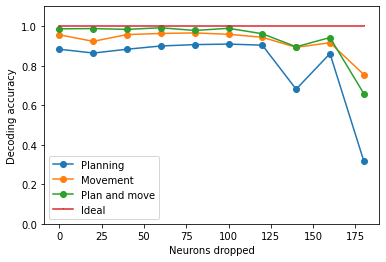

In [21]:
plt.plot(amount_of_neurons, correct_plans, marker="o", label = "Planning")
plt.plot(amount_of_neurons, correct_moves, marker="o", label = "Movement")
plt.plot(amount_of_neurons, correct_plan_moves, marker="o", label = "Plan and move")
plt.plot([0, 180], [1, 1], marker = ",", label="Ideal")
plt.xlabel("Neurons dropped")
plt.ylabel("Decoding accuracy")
plt.legend()
plt.ylim([0, 1.1])
plt.show()

Notice how in the previous graph, the decoding accuracy is constant around 0.9, but after 100 to 130 neurons are dropped, this accuracy number decreases very rapidly.